In [1]:
# ! conda update conda -y
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
use_gpu = False
on_google_colab = False

In [8]:
!pip install torchvision

     |████████████████████████████████| 436 kB 917 kB/s eta 0:00:01


In [5]:
from zipfile import ZipFile
if on_google_colab:
    fn = 'data.zip'

    with ZipFile(fn,'r') as zip:
      zip.extractall()

In [2]:
from models import U_Net
u_net = U_Net()
if use_gpu:
    u_net = U_Net().cuda()

In [3]:
from DataSetClass import RetinaDataset 
tr = torch.utils.data.DataLoader(RetinaDataset('data/training/','data/manual/'), batch_size=8, shuffle=True)
val = torch.utils.data.DataLoader(RetinaDataset('data/validation/','data/validation_manual/'), batch_size=8, shuffle=True)

In [4]:
def get_accuracy():
    y_true, y_pred  = [], []
    with torch.no_grad():
        for i,data in enumerate(val):
            x, y = data
            if use_gpu:
                x, y = x.cuda(), y.cuda()
            # ground truth
            y = list(np.round(y.cpu().numpy()))
            y_true += y
#             print(y)

            pred = u_net(x)
            tmp=np.round(pred.cpu().numpy())
#             for k in range(tmp.shape[0]):
#             assert((tmp[:,0,:,:]+tmp[:,1,:,:]).all()==1)
#             print(np.round(pred.cpu().numpy()).shape)
            # predicted label
            pred = list(np.round(pred.cpu().numpy()))
            y_pred += pred
#             print(np.shape(pred))
#             print(len(y_true))
#             print(len(y_pred))
#             print(pred)
#             break
        
    # calculating overall accuracy
    num_correct = 0
    num_pix = np.shape(y_true[0])[0]*np.shape(y_true[0])[1]*np.shape(y_true[0])[2]
    for i in range(len(y_true)):
#         print(y_pred[i].shape)
        num_correct += np.sum(y_pred[i]==y_true[i])
    print(num_correct,len(y_true),num_pix)
    acc = num_correct/(len(y_true)*num_pix)
    print("Accuracy: ", acc)
    return acc
print(use_gpu)
get_accuracy()

False
3692462 60 131072
Accuracy:  0.4695208231608073


0.4695208231608073

In [5]:
print(use_gpu)

False


In [19]:
use_gpu=True

In [5]:
import torch.optim as optim

optimizer = optim.Adam(u_net.parameters())
# criterion = F.BCELoss()
# criterion = nn.CrossEntropyLoss()
criterion = nn.functional.mse_loss

In [ ]:
loss_history = []
acc_history = []
for epoch in range(50):
    train_loss = 0.0
    for i,data in enumerate(tr):
        x, y = data
        if use_gpu:
            x, y = x.cuda(), y.cuda()
        optimizer.zero_grad()
        y_pred = u_net(x)
        loss = criterion(y_pred, y)
        x = loss.item()
        train_loss += x
        if (i%40==0):
            print('(%d, %5d) item-loss: %.9f'%(epoch + 1, i + 1, x))
        loss.backward()
        optimizer.step()   
    print('[%d] epoch-loss: %.9f'%(epoch + 1, train_loss))
    loss_history.append(train_loss)
    acc_history.append(get_accuracy())
print('Finished Training')

In [17]:
print(len(tr))

50


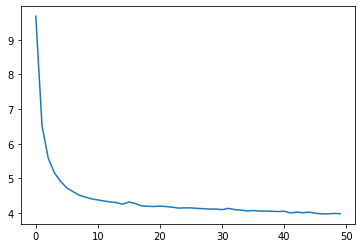

In [8]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

[0.8625740051269531, 0.8652745564778646, 0.8655794779459636, 0.8862335205078125, 0.8945101420084636, 0.9023661295572917, 0.899408467610677, 0.9062512715657552, 0.9117663065592448, 0.9089589436848958, 0.9113038380940756, 0.9103673299153646, 0.9147295633951823, 0.9141705830891927, 0.9155507405598958, 0.9160896301269531, 0.9165918986002605, 0.9116663614908854, 0.917340087890625, 0.9181259155273438, 0.9166638692220052, 0.9164464314778645, 0.9167928059895833, 0.918994140625, 0.9181068420410157, 0.9218416849772135, 0.9184346516927083, 0.9199902852376302, 0.919976552327474, 0.9218513488769531, 0.9209493001302084, 0.9234578450520833, 0.9238858540852865, 0.9200304667154948, 0.923687489827474, 0.9216255187988281, 0.921612803141276, 0.9248146057128906, 0.9241783142089843, 0.925909423828125, 0.9223505655924479, 0.923992411295573, 0.9241477966308593, 0.9224000295003255, 0.9226030985514323, 0.927227274576823, 0.925164794921875, 0.9232065836588542, 0.9254951477050781, 0.9277455647786458]


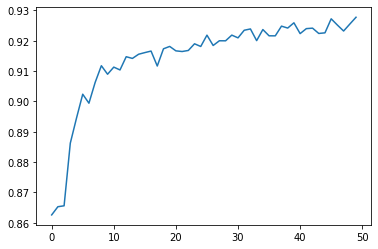

In [9]:
import matplotlib.pyplot as plt
plt.plot(acc_history)
# print(acc_history)

In [ ]:
##saving the model
PATH = 'retina_unet_256_16_.pth'
torch.save(u_net.state_dict(), PATH)

In [6]:
PATH = 'trained_models/retina_unet_256_16_.pth'
##loading the model
model = U_Net()
model.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))
model.eval()

U_Net(
  (enc_conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (max_pool1): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (1): Dropout2d(p=0.5, inplace=False)
  )
  (enc_conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (max_pool2): Sequential(
    (0): MaxPool2d(kernel_size

In [7]:
u_net=model

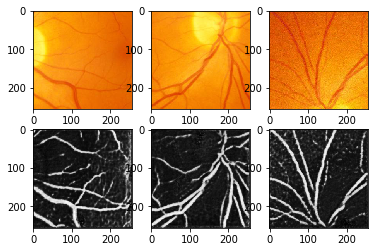

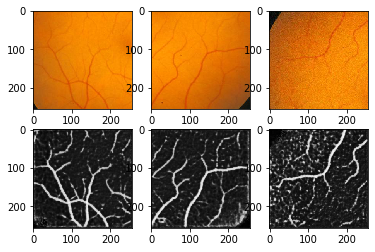

In [55]:
#Showing 2 random segmentations
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision

for i in range(2):
    idx = np.random.randint(100)
    im1 = Image.open('data/training/' + str(idx)  + '_orig.jpg')
    im2 = Image.open('data/training/' + str(idx)  + '_rot.jpg')
    im3 = Image.open('data/training/' + str(idx)  + '_noise.jpg')

    s1 = torchvision.transforms.ToTensor()(im1).unsqueeze(0)
    s2 = torchvision.transforms.ToTensor()(im2).unsqueeze(0)
    s3 = torchvision.transforms.ToTensor()(im3).unsqueeze(0)

    pred1 = u_net(s1).cpu().detach().numpy()
    pred2 = u_net(s2).cpu().detach().numpy()
    pred3 = u_net(s3).cpu().detach().numpy()

    f = plt.figure()
    f.add_subplot(2,3, 1)
    plt.imshow(im1)
    f.add_subplot(2,3, 2)
    plt.imshow(im2)
    f.add_subplot(2,3, 3)
    plt.imshow(im3)
    f.add_subplot(2,3, 4)
    plt.imshow(pred1[0][0],cmap='gray')
    f.add_subplot(2,3, 5)
    plt.imshow(pred2[0][0],cmap='gray')
    f.add_subplot(2,3, 6)
    plt.imshow(pred3[0][0],cmap='gray')

[link text](https://)# Results on Validation Data

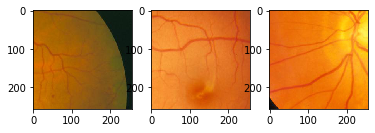

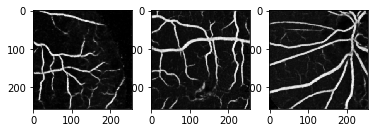

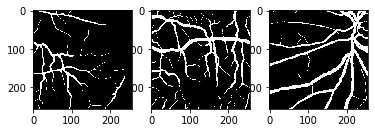

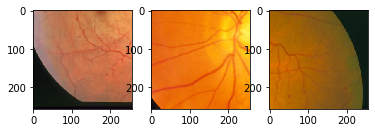

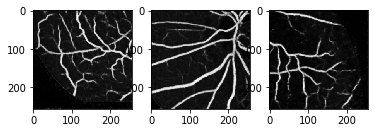

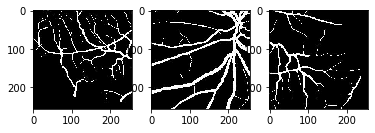

In [10]:
#Showing 2 random segmentations
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision

imgs_folder = 'data/validation/'
lbl_folder = 'data/validation_manual/'

for i in range(2):
    idx = 1+np.random.randint(20)
    idx2 = 1+np.random.randint(20)
    idx3 = 1+np.random.randint(20)
    im1 = Image.open(imgs_folder + str(idx)  + '_orig.jpg')
    im2 = Image.open(imgs_folder + str(idx2)  + '_orig.jpg')
    im3 = Image.open(imgs_folder + str(idx3)  + '_orig.jpg')
    im4 = Image.open(lbl_folder + str(idx)  + '_orig.jpg')
    im5 = Image.open(lbl_folder + str(idx2)  + '_orig.jpg')
    im6 = Image.open(lbl_folder + str(idx3)  + '_orig.jpg')

    s1 = torchvision.transforms.ToTensor()(im1).unsqueeze(0)
    s2 = torchvision.transforms.ToTensor()(im2).unsqueeze(0)
    s3 = torchvision.transforms.ToTensor()(im3).unsqueeze(0)

    pred1 = u_net(s1).cpu().detach().numpy()
    pred2 = u_net(s2).cpu().detach().numpy()
    pred3 = u_net(s3).cpu().detach().numpy()

    f = plt.figure()
    f.add_subplot(1,3, 1)
    plt.imshow(im1)
    f.add_subplot(1,3, 2)
    plt.imshow(im2)
    f.add_subplot(1,3, 3)
    plt.imshow(im3)
    f = plt.figure()
    f.add_subplot(1,3, 1)
    plt.imshow(pred1[0][0],cmap='gray')
    f.add_subplot(1,3, 2)
    plt.imshow(pred2[0][0],cmap='gray')
    f.add_subplot(1,3, 3)
    plt.imshow(pred3[0][0],cmap='gray')
    f = plt.figure()
    f.add_subplot(1,3, 1)
    plt.imshow(im4,cmap='gray')
    f.add_subplot(1,3, 2)
    plt.imshow(im5,cmap='gray')
    f.add_subplot(1,3, 3)
    plt.imshow(im6,cmap='gray')

In [8]:
def evaluate():
    tp,tn,fp,fn=0,0,0,0
    y_true, y_pred  = [], []
    with torch.no_grad():
        for i,data in enumerate(val):
            x, y = data
            if use_gpu:
                x, y = x.cuda(), y.cuda()
            # ground truth
            true_arr=np.round(y.cpu().numpy())
            true_arr=true_arr[:,0,:,:].flatten()
            y = list(np.round(y.cpu().numpy()))
            y_true += y
#             print(y)

            pred = u_net(x)
            # predicted label
#             print(np.round(pred.cpu().numpy()).shape)
            pred_arr=np.round(pred.cpu().numpy())
#             print(pred_arr[:,0,:,:].shape)
            pred_arr=pred_arr[:,0,:,:].flatten()
            pred = list(np.round(pred.cpu().numpy()))
            y_pred += pred
            eq=np.where(pred_arr==true_arr)
            neq=np.where(pred_arr!=true_arr)
            tp+=np.sum(true_arr[eq]==1)
            tn+=np.sum(true_arr[eq]==0)
            fn+=np.sum(true_arr[neq]==1)
            fp+=np.sum(true_arr[neq]==0)
#             print(len(pred_arr),len(true_arr))
#             print(pred)
#             break
        
    # calculating overall accuracy
    num_correct = 0
    num_pix = np.shape(y_true[0])[0]*np.shape(y_true[0])[1]*np.shape(y_true[0])[2]
    for i in range(len(y_true)):
        num_correct += np.sum(y_pred[i]==y_true[i])

    acc = num_correct/(len(y_true)*num_pix)
    sen = tp / (tp + fn)
    spec=tn/ (tn + fp)
    print(tp,tn,fp,fn)
    print("Accuracy: ", acc)
    print("Sensitivity: ", sen)
    print("Specificity  ", spec)
    
    return acc
evaluate()

280338 3370842 32146 248834
Accuracy:  0.9285430908203125
Sensitivity:  0.5297672590386491
Specificity   0.9905535958398913


0.9285430908203125